In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fprojects = [
  ("Nitrit NO2","2023-06-13"),
  ("Nitrit NO2","2023-06-14")
]

metric = "euclidean"
space = "lab"


### load projects


data result folder, reagenz specific

In [2]:
data = None

for fproject in fprojects:

    fname = os.path.join(os.getcwd(),"data",fproject[1],fproject[0],"result",f"{space}.{metric}.values.pickle")
    
    frame = pd.read_pickle(fname)
    frame['project'] = "_".join(fproject)
    frame['date'] = fproject[1]
    if data is None: data = frame
    else: data = pd.concat([data, frame])
        
print(data.to_markdown())

|    | project               |   index |   label | metric    | space   |        l |        a |        b | date       |
|---:|:----------------------|--------:|--------:|:----------|:--------|---------:|---------:|---------:|:-----------|
|  0 | Nitrit NO2_2023-06-13 |       0 |   0.01  | euclidean | lab     | 0.430652 | 0.517578 | 0.562847 | 2023-06-13 |
|  1 | Nitrit NO2_2023-06-13 |       0 |   0.034 | euclidean | lab     | 0.413787 | 0.529351 | 0.56121  | 2023-06-13 |
|  2 | Nitrit NO2_2023-06-13 |       0 |   0.061 | euclidean | lab     | 0.378746 | 0.541572 | 0.559957 | 2023-06-13 |
|  3 | Nitrit NO2_2023-06-13 |       0 |   0.095 | euclidean | lab     | 0.361228 | 0.55648  | 0.558924 | 2023-06-13 |
|  4 | Nitrit NO2_2023-06-13 |       0 |   0.121 | euclidean | lab     | 0.345198 | 0.566267 | 0.559216 | 2023-06-13 |
|  5 | Nitrit NO2_2023-06-13 |       0 |   0.155 | euclidean | lab     | 0.326846 | 0.577057 | 0.558882 | 2023-06-13 |
|  6 | Nitrit NO2_2023-06-13 |       0 |   0.181

### train/test set build

In [3]:
train_set = 'Nitrit NO2_2023-06-13'
test_set = 'Nitrit NO2_2023-06-14'

data['train'] = 0
data.loc[data['project']==train_set,'train'] = 1

In [4]:
# store data to "eval"

fprefix = ".".join(["_".join(fproject) for fproject in fprojects])
fname = os.path.join(os.getcwd(),"eval","%s.%s.%s.csv"%(fprefix,space,metric))

data.to_csv(fname,index=None)

### separate train and test data set

In [5]:
# catch train and test items

findex = 0 # number of sample

train_items = data.loc[((data["index"]==findex) & (data["train"]==1)),:].sort_values(by=["label"])
test_items = data.loc[((data["index"]==findex) & (data["train"]==0)),:].sort_values(by=["label"])

print(f"----- train set {train_set:>25}")
train_items.info()

print(f"\n----- test  set {test_set:>25}")
test_items.info()

----- train set     Nitrit NO2_2023-06-13
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   project  11 non-null     object 
 1   index    11 non-null     int8   
 2   label    11 non-null     float32
 3   metric   11 non-null     object 
 4   space    11 non-null     object 
 5   l        11 non-null     float32
 6   a        11 non-null     float32
 7   b        11 non-null     float32
 8   date     11 non-null     object 
 9   train    11 non-null     int64  
dtypes: float32(4), int64(1), int8(1), object(4)
memory usage: 715.0+ bytes

----- test  set     Nitrit NO2_2023-06-14
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   project  14 non-null     object 
 1   index    14 non-null     int8   
 2   label    14 non-null

### OLS 3d regression

In [6]:
# training data

L = train_items["l"].to_numpy(dtype=np.float32)
a = train_items["a"].to_numpy(dtype=np.float32)
b = train_items["b"].to_numpy(dtype=np.float32)
z = train_items["label"].to_numpy(dtype=np.float32)

i = np.argsort(z)
L,a,b,z = L[i],a[i],b[i],z[i]

train_data = pd.DataFrame({'L': L, 'a': a, 'b': b, 'z': z})

from statsmodels.formula.api import ols

# formula by train_data
# z: target
# L,a,b: dependent variables to find coefficients

formula = "z ~ L + a + b"

# build model

model = ols(formula, train_data).fit()

print("--- params\n", model._results.params)
print("--- std. errors\n", model._results.bse)
print("--- pred. values\n", model._results.predict())

print("--- summary")
print(model.summary())

# ! dimensions correlated, given by kurtosis test


--- params
 [-4.5289885  -0.69335474  1.66284858  7.06554825]
--- std. errors
 [0.25929021 0.14922105 0.22997449 0.67512167]
--- pred. values
 [0.00989512 0.02959436 0.06535885 0.09499843 0.1244518  0.15275668
 0.18281524 0.21098792 0.24665405 0.28205096 0.30843659]
--- summary
                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3402.
Date:                Tue, 18 Jul 2023   Prob (F-statistic):           1.96e-11
Time:                        17:59:47   Log-Likelihood:                 50.237
No. Observations:                  11   AIC:                            -92.47
Df Residuals:                       7   BIC:                            -90.88
Df Model:                           3                                         
Covariance

d:\Environment\venv-wisa\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### plot the model regressor for taget variables

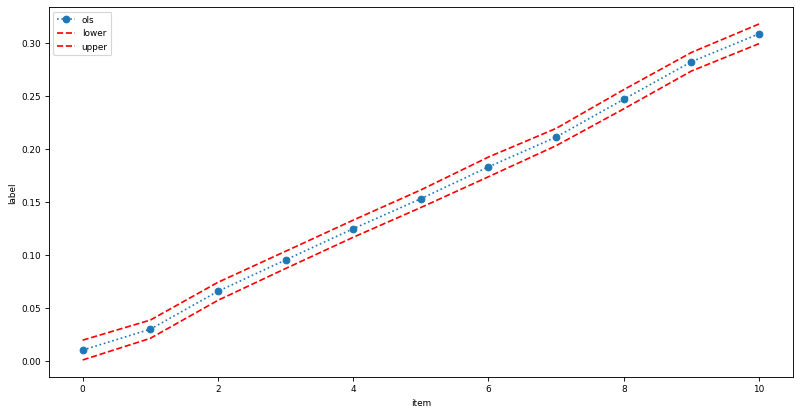

In [7]:
pred_ols = model._results.get_prediction()

iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

iv_l,iv_u

# ---------------------------

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

w = 12
h = 6

nrows,ncols = 1,1
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[w*ncols,h*nrows],
                    dpi=plt.rcParams["figure.dpi"])

ax.plot(model._results.fittedvalues,"o:",label="ols")
ax.plot(iv_l,"r--",label="lower")
ax.plot(iv_u,"r--",label="upper")


ax.legend()
ax.set_ylabel("label")
ax.set_xlabel("item")

plt.show()
plt.close()

In [8]:
from statsmodels.stats.anova import anova_lm

anova_results = anova_lm(model)
print(anova_results)

           df    sum_sq   mean_sq            F        PR(>F)
L         1.0  0.093477  0.093477  9413.649446  3.255501e-12
a         1.0  0.006784  0.006784   683.157195  3.070276e-08
b         1.0  0.001088  0.001088   109.528626  1.583694e-05
Residual  7.0  0.000070  0.000010          NaN           NaN


### predict with OLS model test data

In [9]:
L = test_items["l"].to_numpy(dtype=np.float32)
a = test_items["a"].to_numpy(dtype=np.float32)
b = test_items["b"].to_numpy(dtype=np.float32)
z_test = test_items["label"].to_numpy(dtype=np.float32)

test_data = pd.DataFrame({'L': L, 'a': a, 'b': b, 'z' : z_test})

z_pred = model.predict(test_data).to_numpy()

mse_test = np.mean((z_test-z_pred)**2)

print("test",mse_test)

test 0.0011207765798804325


In [10]:
# compare for conv.

z_train = model.predict(train_data).to_numpy()
mse_train = np.mean((z-z_train)**2)

print("train",mse_train)

train 6.319075837941838e-06


### plot the result

how test data fits to prediction

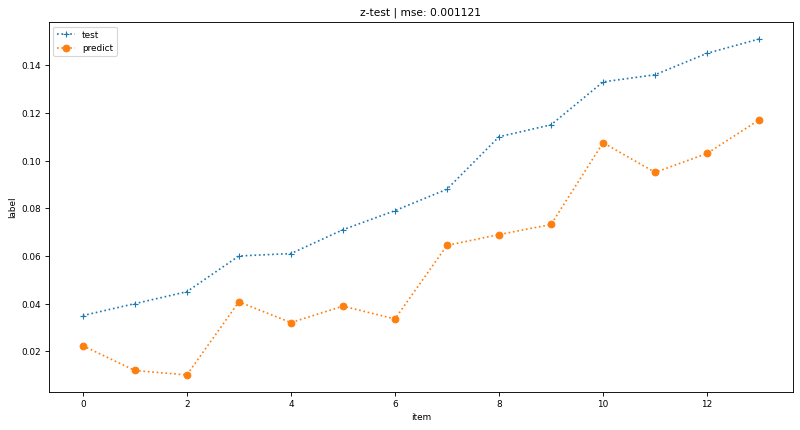

In [11]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

w = 12
h = 6

nrows,ncols = 1,1
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[w*ncols,h*nrows],
                    dpi=plt.rcParams["figure.dpi"])

ax.plot(z_test,"+:",label="test")
ax.plot(z_pred,"o:",label="predict")
ax.set_title(f"z-test | mse: {mse_test:.6f}")

ax.legend()
ax.set_ylabel("label")
ax.set_xlabel("item")

plt.show()
plt.close()
